In [1]:
from avalanche.benchmarks import SplitMNIST, SplitCIFAR10
import lovely_tensors as lt
from torchvision import transforms, datasets
import torch
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import shutup;
import pytorch_lightning as pl
import os 
from src.utils.shift_class_targets import shift_experiences_classes

os.environ['PYTORCH_ENABLE_MPS_FALLBACK']="1"
os.environ["WANDB_START_METHOD"] = "thread"

shutup.please()
pl.seed_everything(42)
lt.monkey_patch()

Global seed set to 42


In [2]:
seed = 42

benchmark = SplitCIFAR10(
    n_experiences=5,
    return_task_id=True,
    shuffle=False,
    dataset_root='./datasets',
    train_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
    eval_transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]),
)
shift_experiences_classes(benchmark, num_tasks_in_batch=2)

train_dataset = datasets.CIFAR10(
    root='./datasets',
    train=True,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0)),
        ]
    ),
)
test_dataset = datasets.CIFAR10(
    root='./datasets',
    train=False,
    transform=transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0)),
        ]
    ),
)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import wandb
import argparse
from train_utils import get_device, add_arguments, get_wandb_params
from src.vq_vae.init_scrips import get_model
from src.utils.train_script import overwrite_config_with_args, parse_arguments
from configparser import ConfigParser
from src.vq_vae.configuration.config import TrainConfig

ini_config = ConfigParser()
ini_config.read("../src/vq_vae/configuration/train.ini")

parser = argparse.ArgumentParser(description="Model trainer")
parser = add_arguments(parser)

## Read args
args = parse_arguments(parser)
args.accelerator = "mps"
args.train_logger = "tensorboard"
args.evaluation_logger = "int"
args.max_epochs = 300
args.min_epochs = 300
args.num_workers = 0
args.regularization_dropout = 0.2
args.regularization_lambda = 0.01
args.learning_rate = 0.001
args.batch_size = 32
args.best_model_prefix = "artifacts"
args.num_random_noise = 0
args.model = "vq-vae"

config = TrainConfig.construct_typed_config(ini_config)
overwrite_config_with_args(args, config)

is_using_wandb = (
    config.train_logger == "wandb"
    or config.evaluation_logger == "wandb"
    or args.run_id
)
if is_using_wandb:
    wandb_params = get_wandb_params(args, config)

    wandb.run.name = args.experiment_name or (
        f"RI-0."
        f"RN-{config.num_random_noise}."
        f"Dr-{config.regularization_dropout}."
        f"Wd-{config.regularization_lambda}."
    )
    wandb_params["name"] = wandb.run.name
else:
    wandb_params = None

In [4]:
from avalanche.training.plugins import EvaluationPlugin
from train_utils import get_loggers
from src.avalanche.strategies import NaivePytorchLightning
from src.vq_vae.model.vq_vae import VQVae

device = get_device(config)
vq_vae_model = VQVae(
    num_hiddens=config.num_hiddens,
    num_residual_layers=config.num_residual_layers,
    num_residual_hiddens=config.num_residual_hiddens,
    num_embeddings=config.num_embeddings,
    embedding_dim=config.embedding_dim,
    commitment_cost=config.commitment_cost,
    decay=config.decay,
    learning_rate=config.learning_rate,
    regularization_lambda=config.regularization_lambda,
    regularization_dropout=config.regularization_dropout,
    data_variance=0.06328692405746414,
    use_lpips=True,
)

Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /Users/ewriji/Library/Caches/pypoetry/virtualenvs/rnd-ve5eq-PE-py3.10/lib/python3.10/site-packages/lpips/weights/v0.1/vgg.pth


In [5]:
from src.vq_vae.init_scrips import get_evaluation_plugin, get_callbacks

train_experience, test_experience = next(iter(zip(benchmark.train_stream, benchmark.test_stream)))
# Test trained model
cl_strategy_logger, eval_plugin_loggers = get_loggers(config, vq_vae_model, wandb_params)
evaluation_plugin = EvaluationPlugin(
    suppress_warnings=True,
)

cl_strategy = NaivePytorchLightning(
    accelerator=config.accelerator,
    devices=config.devices,
    validate_every_n=config.validate_every_n,
    accumulate_grad_batches=config.accumulate_grad_batches,
    train_logger=cl_strategy_logger,
    initial_resume_from=args.resume_from,
    model=vq_vae_model,
    device=device,
    optimizer=vq_vae_model.configure_optimizers(),
    criterion=vq_vae_model.criterion,
    train_mb_size=config.batch_size,
    train_mb_num_workers=config.num_workers,
    train_epochs=config.max_epochs,
    eval_mb_size=config.batch_size,
    evaluator=evaluation_plugin,
    callbacks=get_callbacks(config),
    max_epochs=config.max_epochs,
    min_epochs=config.min_epochs,
    best_model_path_prefix=config.best_model_prefix,
    plugins=[],
)

# cl_strategy.train(train_experience, [test_experience])

In [6]:
cl_strategy.model is vq_vae_model

True

In [7]:

# Test trained model
test_dataset =  benchmark.test_stream[4].dataset
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

cl_strategy.model.eval()
losses = []
targets = []

with torch.no_grad():
    for batch in tqdm(test_dataloader):
        x, y, *_ = batch
        x, y = x.to(vq_vae_model.device), y.to(vq_vae_model.device)

        z = vq_vae_model.encoder(x)
        z = vq_vae_model.pre_vq_conv(z)
        vq_loss, quantized, perplexity = vq_vae_model.vq_vae(z)
        x_recon = vq_vae_model.decoder(quantized)

        _, reconstruction_loss, clf_loss, clf_acc, _ = vq_vae_model.criterion(
            (vq_loss, x_recon, quantized, x, perplexity, None), y
        )
        loss = vq_loss + reconstruction_loss

        losses.append(loss)
        targets.extend(y.tolist())

avg_test_loss = torch.tensor(losses).mean()
print(avg_test_loss)

  0%|          | 0/8 [00:00<?, ?it/s]

tensor 0.850


In [10]:
quantized

tensor[256, 64, 1, 1] n=16384 x∈[-1.839, 1.535] μ=0.064 σ=0.717

In [27]:
from torch import nn
from src.vq_vae.model.resnet import ResidualStack

num_hiddens = 128
num_residual_layers = 2
num_residual_hiddens = 32
regularization_dropout = 0.2

_model = nn.Sequential(

    # nn.Conv2d(
    #     in_channels=64,
    #     out_channels=num_hiddens,
    #     kernel_size=3,
    #     stride=1,
    #     padding=1,
    # ),
    # ResidualStack(
    #     in_channels=num_hiddens,
    #     num_hiddens=num_hiddens,
    #     num_residual_layers=num_residual_layers,
    #     num_residual_hiddens=num_residual_hiddens,
    #     regularization_dropout=regularization_dropout,
    # ),
    # nn.ConvTranspose2d(
    #     in_channels=num_hiddens,
    #     out_channels=num_hiddens,
    #     kernel_size=4,
    #     stride=2,
    #     padding=1,
    # ),
    # nn.ReLU(),
    # nn.ConvTranspose2d(
    #     in_channels=num_hiddens,
    #     out_channels=num_hiddens // 2,
    #     kernel_size=4,
    #     stride=2,
    #     padding=1,
    # ),
    # nn.ReLU(),
    # nn.ConvTranspose2d(
    #     in_channels=num_hiddens // 2,
    #     out_channels=3,
    #     kernel_size=4,
    #     stride=2,
    #     padding=1,
    # ),
)

_model(quantized).shape

torch.Size([256, 64, 8, 8])

In [18]:
from torch.utils.data import ConcatDataset

ConcatDataset(
    [experience.dataset for experience in benchmark.train_stream[: ]]
)

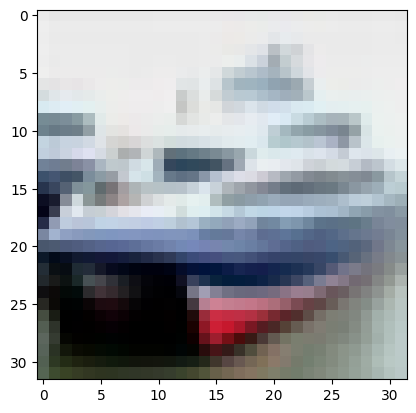

In [25]:
from matplotlib import pyplot as plt

plt.imshow(test_dataset[0][0].permute(1, 2, 0).cpu() + 0.5)

In [26]:
for param in vq_vae_model.cpu().parameters():
    print(param.data)

tensor[64, 3, 4, 4] n=3072 x∈[-0.144, 0.144] μ=-0.001 σ=0.083
tensor[64] x∈[-0.143, 0.129] μ=-0.003 σ=0.074
tensor[128, 64, 4, 4] n=131072 x∈[-0.031, 0.031] μ=5.904e-05 σ=0.018
tensor[128] x∈[-0.031, 0.031] μ=0.001 σ=0.016
tensor[128, 128, 3, 3] n=147456 x∈[-0.029, 0.029] μ=-4.499e-05 σ=0.017
tensor[128] x∈[-0.029, 0.028] μ=0.000 σ=0.017
tensor[32, 128, 3, 3] n=36864 x∈[-0.029, 0.029] μ=-4.836e-05 σ=0.017
tensor[128, 32, 1, 1] n=4096 x∈[-0.177, 0.177] μ=0.001 σ=0.102
tensor[32, 128, 3, 3] n=36864 x∈[-0.029, 0.029] μ=-0.000 σ=0.017
tensor[128, 32, 1, 1] n=4096 x∈[-0.177, 0.177] μ=0.001 σ=0.101
tensor[64, 128, 1, 1] n=8192 x∈[-0.088, 0.088] μ=-0.001 σ=0.051
tensor[64] x∈[-0.086, 0.086] μ=-0.000 σ=0.052
tensor[512, 64] n=32768 x∈[-3.976, 4.122] μ=0.004 σ=0.996
tensor[512, 64] n=32768 x∈[-3.907, 3.927] μ=-0.001 σ=1.003
tensor[128, 64, 3, 3] n=73728 x∈[-0.042, 0.042] μ=0.000 σ=0.024
tensor[128] x∈[-0.041, 0.041] μ=-0.001 σ=0.024
tensor[32, 128, 3, 3] n=36864 x∈[-0.029, 0.029] μ=-4.161e-05 σ

In [11]:
type(benchmark)

avalanche.benchmarks.scenarios.new_classes.nc_scenario.NCScenario